# Preprocesamiento de las secuencias genómicas SARS-CoV-2

### Instalación de Librerías

In [1]:
!pip install plotly

In [2]:
!pip install Bio

In [3]:
!pip install pygrok

In [4]:
!pip install -U scikit-learn scipy matplotlib

### Importación de librerias

In [5]:
import warnings
warnings.filterwarnings('ignore')
#Librería para el formato de fecha
from pygrok import Grok
#Librería bioinformática
from Bio import SeqIO, Seq
from Bio.SeqIO.FastaIO import FastaIterator
from Bio.Align import MultipleSeqAlignment
#Librerías para los datos
import numpy as np
import pandas as pd
from datetime import date
import operator
import collections
from collections import Counter, defaultdict
#Librería de preprocesamiento y reducción de dimensionalidad
from sklearn.preprocessing import StandardScaler,scale
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.manifold import MDS
#Librería de distancia
from scipy.spatial.distance import pdist, hamming, squareform
#Librerías para gráficos
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

### Lectura del archivo FASTA con todas las secuencias genómicas SARS-CoV-2

- Variables iniciales

In [6]:
grok = Grok('%{YEAR:year}-%{MONTHNUM:month}-%{MONTHDAY:day}')
lista = ['AMA','ANC','APU','ARE','AYA','CAJ','CUS','HUV','HUC','HVC','HUA','HCV','HUN','ICA','JUN','LAL','LAM','LIM','LOR','MDD','MOQ','PAS','PIU','PUN','SAM','TAC','TUM','UCA','CAL','C01','C02','C03']
diccionario = {'AMA' : 'Amazonas','ANC' : 'Áncash','APU' : 'Apurímac','ARE' : 'Arequipa',
               'AYA' : 'Ayacucho','CAJ' : 'Cajamarca','CUS' : 'Cusco',
               'HUV' : 'Huancavelica','HUC' : 'Huánuco',
               'HVC' : 'Huancavelica','HUA' : 'Huánuco',
               'HCV' : 'Huancavelica','HUN' : 'Huánuco',
               'ICA' : 'Ica','JUN' : 'Junín','LAL' : 'La Libertad',
               'LAM' : 'Lambayeque','LIM' : 'Lima','LOR' : 'Loreto','MDD' : 'Madre de Dios',
               'MOQ' : 'Moquegua','PAS' : 'Pasco','PIU' : 'Piura','PUN' : 'Puno',
               'SAM' : 'San Martín','TAC' : 'Tacna','TUM' : 'Tumbes','UCA' : 'Ucayali',
               'CAL' : 'Callao', 'C01' : 'Callao', 'C02': 'Callao','C03': 'Callao'}

- Lectura de archivos

In [7]:
registros = list(SeqIO.parse("gisaid_hcov-19_2021_09_01_02.fasta", "fasta"))
print("Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta:",len(registros))

Cantidad de secuencias genómicas SARS-CoV-2 en el archivo .fasta: 3948


### Obtención del código, la fecha de recolección y el lugar de donde se obtuvo cada secuencia genómica SARS-CoV-2

In [8]:
abrevPlaces=list() #Lista de las abreviaciones de los lugares
fechas=list() #Lista de las fechas
secuencias=list() #Lista de las secuencias
secuenciasEliminadas=list() #Lista de las secuencias eliminadas
for i in range(len(registros)):
    name=registros[i].id
    #Obtener la abreviación del nombre del departamento
    primer_indice=name.find('/')
    segundo_indice = name.find('/', primer_indice + 1)
    place=name[segundo_indice+1:segundo_indice+4]
    #Secuencias que no tienen un lugar definido
    if not place in lista:
        secuenciasEliminadas.append(registros[i])
        continue
    else:
        if not place in abrevPlaces:
            abrevPlaces.append(place)
        #Obtener el código de la secuencia
        primer_indice=name.find('|')
        segundo_indice = name.find('|', primer_indice + 1)
        codigo=name[primer_indice+1:segundo_indice]
        #Obtener la fecha de recolección
        valor=grok.match(name)
        if valor == None:
            secuenciasEliminadas.append(registros[i])
            continue
        else:
            fecha=valor['year'] + '-' + valor['month'] + '-' + valor['day']
            #Guardar los datos obtenidos
            registros[i].name=diccionario[place]
            registros[i].description=fecha   
            registros[i].id=codigo 
            fechas.append(fecha)
            #Guardar la secuencia
            secuencias.append(registros[i])
print("Cantidad de secuencias eliminadas:",len(secuenciasEliminadas))

Cantidad de secuencias eliminadas: 39


### Eliminación de las secuencias genómicas SARS-CoV-2 con errores de lectura

In [9]:
#Eliminamos las secuencias con errores de lectura en el archivo fasta (definido como letras distintas de A, C, G, T).
pos,cantSecEli=0,0
while pos<len(secuencias):
    registro=set(secuencias[pos].seq)
    if 'N' in registro or 'K' in registro or 'M' in registro or 'R' in registro or 'S' in registro or 'W' in registro or 'Y' in registro:
        secuencias.pop(pos)
        cantSecEli+=1
    else:
        pos+=1
print("Cantidad de secuencias eliminadas:",cantSecEli)
print("Cantidad de secuencias a preprocesar:",len(secuencias))

Cantidad de secuencias eliminadas: 2586
Cantidad de secuencias a preprocesar: 1323


### Alineamiento múltiple de las secuencias genómicas SARS-CoV-2

In [10]:
maxlongitud = max(len(registro.seq) for registro in secuencias)
for registro in secuencias:
    secuencia = str(registro.seq)
    registro.seq = Seq.Seq(secuencia[:1273])
secuenciasAlineadas = MultipleSeqAlignment(secuencias)
print(secuenciasAlineadas)

Alignment with 1323 rows and 1273 columns
TTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTG...GCC EPI_ISL_415787
CAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCA...TCG EPI_ISL_482468
GGACACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTT...TAA EPI_ISL_487269
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489836
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489837
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489838
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489839
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489987
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489988
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489989
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_489990
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_490209
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_490315
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGC...CTT EPI_ISL_490316
CTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCG

### Calculo de la matriz de distancia Hamming

- Convertir las secuencias genómicas SARS-CoV-2 a una matriz

In [11]:
matriz_secuencias= np.array([ list(secuencia.seq) for secuencia in secuenciasAlineadas])
matriz_secuencias

array([['T', 'T', 'A', ..., 'G', 'C', 'C'],
       ['C', 'A', 'G', ..., 'T', 'C', 'G'],
       ['G', 'G', 'A', ..., 'T', 'A', 'A'],
       ...,
       ['C', 'A', 'A', ..., 'A', 'A', 'T'],
       ['A', 'C', 'C', ..., 'A', 'C', 'T'],
       ['T', 'C', 'C', ..., 'C', 'G', 'A']], dtype='<U1')

- Función para calcular la distancia Hamming

In [12]:
def ham(seq1,seq2):
    return (hamming(seq1,seq2) * len(seq1))

- Calcular una matriz de distancia condensada

In [13]:
distancia_condensada=pdist(matriz_secuencias, ham)
dist_condensada=np.around(np.array(distancia_condensada),2)

- Convertir la matriz de distancia condensada a matriz de distancia completa

In [14]:
matriz_distancias=squareform(dist_condensada)

### Realizar el escalamiento multidimensional (MDS)

In [15]:
mds = MDS(n_components=100, metric=False, max_iter=3000, eps=1e-12,
                    dissimilarity="precomputed", random_state=0, n_jobs=1,
                    n_init=1)
matriz_mds=mds.fit_transform(matriz_distancias)
print("Coordenadas de las secuencias genómicas SARS-CoV-2")
matriz_mds

Coordenadas de las secuencias genómicas SARS-CoV-2


array([[ 0.00606126,  0.02661841,  0.01596407, ..., -0.0864412 ,
         0.05946762, -0.08790912],
       [ 0.02614894, -0.03447207,  0.0413848 , ..., -0.04604643,
        -0.07628736, -0.0177136 ],
       [-0.02803425,  0.03394515, -0.02723374, ...,  0.06050425,
         0.07831635,  0.07328115],
       ...,
       [ 0.07292322,  0.09150828, -0.07087852, ...,  0.02522457,
         0.06428841, -0.07056958],
       [-0.0651136 ,  0.0415876 , -0.06499878, ..., -0.08484634,
        -0.01726174,  0.0838667 ],
       [ 0.03941768,  0.05469877, -0.03291239, ..., -0.08935354,
        -0.00478162,  0.04000234]])

### Realizar el análisis de componentes principales (PCA)

Tamaño de X_pca (1323, 93)


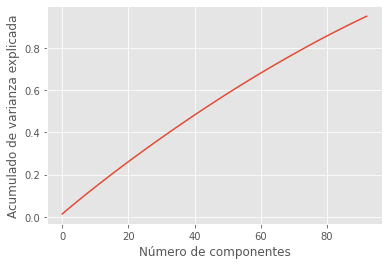

In [16]:
pca=PCA(.95) 
pca.fit(matriz_mds)
X_pca=pca.transform(matriz_mds) 
print("Tamaño de X_pca", X_pca.shape)
#Grafica del acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Acumulado de varianza explicada')
plt.show()

In [17]:
print("Componentes principales")
X_pca

Componentes principales


array([[ 0.03662219, -0.15277018,  0.12044988, ...,  0.02558608,
         0.02281786,  0.03321645],
       [-0.044128  , -0.0222438 ,  0.03573266, ...,  0.02967115,
         0.04445772, -0.02729193],
       [-0.04202697,  0.05318318, -0.07644464, ..., -0.01824486,
         0.04680133,  0.07405418],
       ...,
       [-0.01452329, -0.12706134,  0.14327821, ..., -0.07107436,
        -0.00967543,  0.02932787],
       [-0.11247289, -0.06330221, -0.01651854, ..., -0.01837534,
         0.03533256,  0.01172027],
       [-0.01203776,  0.03488903,  0.13471966, ..., -0.0002573 ,
         0.14118676,  0.08524331]])